In [1]:
# !pip install --upgrade pip setuptools wheel


In [2]:
# !pip install pystan==2.19.1.1


Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [4]:
data=pd.read_csv("/content/drive/MyDrive/Main Project/Models/Energy Consumption data site id 8.csv")
data.head()

,Date,Timestamp,year,Month,Temperature,Holiday,Is_Working_Day,Values
0,2013-03-21,2013-03-21 00:00:00+00:00,2013,3,13.0,Working Day,1,51.953817
1,2013-03-22,2013-03-22 00:00:00+00:00,2013,3,15.0,Working Day,1,42.459353
2,2013-03-23,2013-03-23 00:00:00+00:00,2013,3,15.0,Working Day,1,34.399994
3,2013-03-24,2013-03-24 00:00:00+00:00,2013,3,14.8,Working Day,1,35.669267
4,2013-03-25,2013-03-25 00:00:00+00:00,2013,3,19.0,Working Day,1,52.242278


In [5]:
data.tail()

,Date,Timestamp,year,Month,Temperature,Holiday,Is_Working_Day,Values
1441,2017-03-01,2017-03-01 00:00:00+00:00,2017,3,17.00,Working Day,1,31.927374
1442,2017-03-02,2017-03-02 00:00:00+00:00,2017,3,17.00,Working Day,1,30.958712
1443,2017-03-03,2017-03-03 00:00:00+00:00,2017,3,16.00,Working Day,1,31.299375
1444,2017-03-04,2017-03-04 00:00:00+00:00,2017,3,15.75,Working Day,1,17.386416
1445,2017-03-05,2017-03-05 00:00:00+00:00,2017,3,15.40,Working Day,1,16.265874


In [6]:
data['Timestamp']=pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp',inplace=True)
data.head()

,Date,year,Month,Temperature,Holiday,Is_Working_Day,Values
Timestamp,,,,,,,
2013-03-21 00:00:00+00:00,2013-03-21,2013,3,13.0,Working Day,1,51.953817
2013-03-22 00:00:00+00:00,2013-03-22,2013,3,15.0,Working Day,1,42.459353
2013-03-23 00:00:00+00:00,2013-03-23,2013,3,15.0,Working Day,1,34.399994
2013-03-24 00:00:00+00:00,2013-03-24,2013,3,14.8,Working Day,1,35.669267
2013-03-25 00:00:00+00:00,2013-03-25,2013,3,19.0,Working Day,1,52.242278


In [7]:
consumption_df_final=data.reset_index()[['Timestamp','Date','year','Month','Temperature','Holiday','Is_Working_Day','Values']].rename({'Timestamp':'ds','Values':'y','Month':'month',"Temperature":'temp'},axis='columns')
consumption_df_final.head()

,ds,Date,year,month,temp,Holiday,Is_Working_Day,y
0,2013-03-21 00:00:00+00:00,2013-03-21,2013,3,13.0,Working Day,1,51.953817
1,2013-03-22 00:00:00+00:00,2013-03-22,2013,3,15.0,Working Day,1,42.459353
2,2013-03-23 00:00:00+00:00,2013-03-23,2013,3,15.0,Working Day,1,34.399994
3,2013-03-24 00:00:00+00:00,2013-03-24,2013,3,14.8,Working Day,1,35.669267
4,2013-03-25 00:00:00+00:00,2013-03-25,2013,3,19.0,Working Day,1,52.242278


In [8]:
fig = px.line(consumption_df_final, x='ds', y='y',hover_data=['temp','month','Is_Working_Day'], title='Energy Consumption')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='1y', step='year', stepmode='backward'),
            dict(count=2, label='2y', step='year', stepmode='backward'),
            dict(count=3, label='5y', step='year', stepmode='backward'),
            dict(step='all')
        ])
    )
)

fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [9]:
consumption_df_final[['month','temp']].groupby('month').agg({'temp':{'max','min','mean'}})

temp             
            mean    min   max
month                        
1      16.373387  11.00  24.0
2      16.589823  11.00  25.0
3      14.815138   9.00  22.0
4      12.247083   7.00  23.0
5       9.853629  -1.00  20.0
6       7.017500  -0.20  16.5
7       6.660081  -0.55  15.0
8       7.179032   1.00  16.0
9       9.084167   5.00  18.0
10     11.786290   6.00  21.0
11     13.490833   6.00  23.0
12     15.264113   9.00  24.0

In [10]:
#Checking correlation between Energy consumption and Temperature

consumption_df_final[['y','temp']].corr()

,y,temp
y,1.000000,-0.423538
temp,-0.423538,1.000000


In [11]:
consumption_df_final=consumption_df_final.drop(columns=['Date','year','Holiday'])

In [12]:
def summer_temp(temp):
  if temp > 20:
    return 1
  else:
    return 0

In [13]:
consumption_df_final['summer_temp']=consumption_df_final['temp'].apply(summer_temp)

consumption_df_final['month_bins']=pd.cut(consumption_df_final['month'],bins=3, labels=False)
consumption_df_final.head()

,ds,month,temp,Is_Working_Day,y,summer_temp,month_bins
0,2013-03-21 00:00:00+00:00,3,13.0,1,51.953817,0,0
1,2013-03-22 00:00:00+00:00,3,15.0,1,42.459353,0,0
2,2013-03-23 00:00:00+00:00,3,15.0,1,34.399994,0,0
3,2013-03-24 00:00:00+00:00,3,14.8,1,35.669267,0,0
4,2013-03-25 00:00:00+00:00,3,19.0,1,52.242278,0,0


In [14]:
train = consumption_df_final[(consumption_df_final['ds'] >= '2013-03-21') & (consumption_df_final['ds'] <= '2016-08-01')]
test = consumption_df_final[consumption_df_final['ds'] > '2016-08-01']

In [15]:
print("Shape of train data:",train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (1230, 7)
Shape of test data: (216, 7)


Prophet modeling

In [16]:
m=Prophet(interval_width=0.95,yearly_seasonality=True)

In [17]:
m.add_regressor('summer_temp',standardize=False)
m.add_regressor('month_bins',standardize=False,mode='multiplicative')
m.add_regressor('Is_Working_Day', standardize=False)

In [18]:
# Remove timezone information from the 'ds' column in the 'train' DataFrame
train['ds'] = train['ds'].dt.tz_localize(None)

# Now try fitting the model again
m.fit(train)

<ipython-input-18-a6444166408e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa1v0v6yf/__hm_h3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa1v0v6yf/bt_1eocz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97377', 'data', 'file=/tmp/tmpa1v0v6yf/__hm_h3k.json', 'init=/tmp/tmpa1v0v6yf/bt_1eocz.json', 'output', 'file=/tmp/tmpa1v0v6yf/prophet_modelibrgh3ui/prophet_model-20240826043325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:25 - cm

In [19]:
m.params

OrderedDict([('lp__', array([[2534.99]])),
             ('k', array([[-0.327953]])),
             ('m', array([[0.588193]])),
             ('delta',
              array([[-4.48516e-08, -6.30774e-08,  4.95912e-08,  1.06930e-04,
                       2.08468e-04,  2.21653e-04,  5.34908e-03,  4.13637e-02,
                       9.09176e-02,  1.13182e-01,  1.11132e-01,  1.22623e-01,
                       7.50796e-02,  3.13400e-07, -3.85357e-08, -4.98838e-08,
                       6.16508e-09, -1.32620e-06, -3.18990e-02, -8.12670e-02,
                      -1.09033e-01, -1.38404e-01, -9.90205e-02, -2.64589e-08,
                      -4.69165e-08]])),
             ('sigma_obs', array([[0.0759004]])),
             ('beta',
              array([[-0.0757862 , -0.14734   , -0.0641198 , -0.0859233 ,  0.00523733,
                      -0.0326436 , -0.0328197 , -0.0438919 ,  0.028949  ,  0.0368553 ,
                      -0.00074068, -0.0338053 ,  0.00467989, -0.00098271, -0.00880392,
          

In [20]:
# future= m.make_future_dataframe(periods=len(test))
future = m.make_future_dataframe(periods=len(test), include_history=True)
future.tail()

,ds
1441,2017-03-01
1442,2017-03-02
1443,2017-03-03
1444,2017-03-04
1445,2017-03-05


In [21]:
# future['summer_temp']=test['summer_temp']
# future['month_bins']=test['month_bins']
# future['Is_Working_Day']=test['Is_Working_Day']
future['summer_temp'] = pd.concat([train['summer_temp'], test['summer_temp']], axis=0)
future['month_bins'] = pd.concat([train['month_bins'], test['month_bins']], axis=0)
future['Is_Working_Day'] = pd.concat([train['Is_Working_Day'], test['Is_Working_Day']], axis=0)

In [22]:
future

,ds,summer_temp,month_bins,Is_Working_Day
0,2013-03-21,0,0,1
1,2013-03-22,0,0,1
2,2013-03-23,0,0,1
3,2013-03-24,0,0,1
4,2013-03-25,0,0,1
...,...,...,...,...
1441,2017-03-01,0,0,1
1442,2017-03-02,0,0,1
1443,2017-03-03,0,0,1
1444,2017-03-04,0,0,1


In [23]:
# print(future['summer_temp'].isnull().sum())
# future.dropna(subset=['summer_temp'], inplace=True)

In [24]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1441,2017-03-01,34.601327,23.787713,45.124716
1442,2017-03-02,34.479912,24.531936,44.876634
1443,2017-03-03,28.792849,18.022794,38.941581
1444,2017-03-04,16.817850,6.438139,27.352898
1445,2017-03-05,16.615052,6.322786,27.582061


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



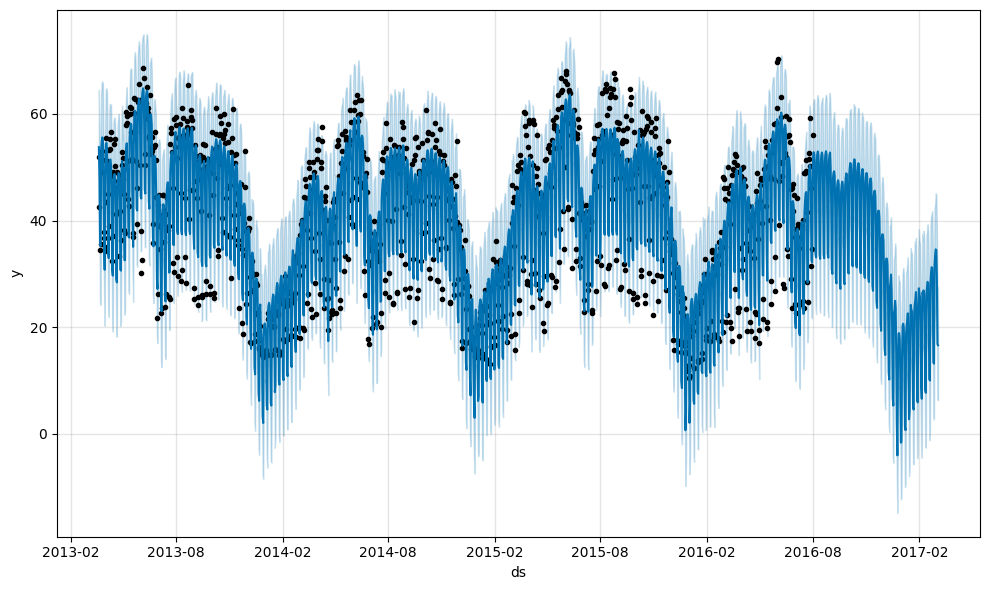

In [25]:
## Ploting actual value and predicated value
f1=m.plot(forecast)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavio

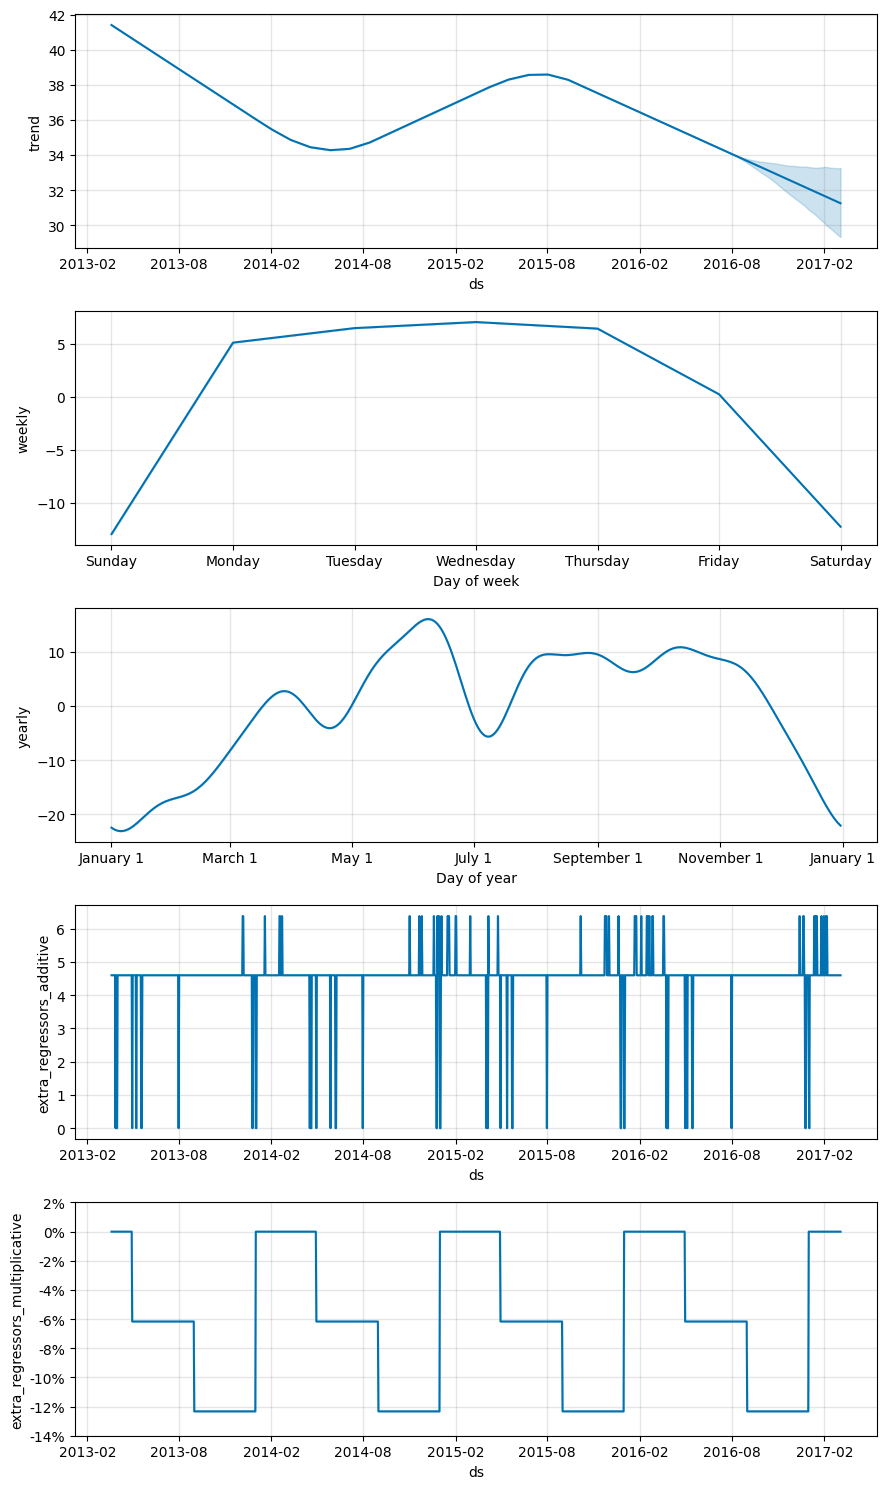

In [26]:
# Plot the components of the model

fig2=m.plot_components(forecast)

In [27]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model=m,initial = '731 days', horizon = '365 days')
df_p=performance_metrics(df_cv)
df_p

INFO:prophet:Making 1 forecasts with cutoffs between 2015-08-02 00:00:00 and 2015-08-02 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpa1v0v6yf/l333lus8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa1v0v6yf/n6rk5w_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13802', 'data', 'file=/tmp/tmpa1v0v6yf/l333lus8.json', 'init=/tmp/tmpa1v0v6yf/n6rk5w_p.json', 'output', 'file=/tmp/tmpa1v0v6yf/prophet_modeldl73qirp/prophet_model-20240826043329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,47.378562,6.883209,6.225216,0.130094,0.119880,0.129810,0.861111
1,37 days,47.199832,6.870213,6.192764,0.129388,0.119880,0.129184,0.861111
2,38 days,45.427334,6.739980,6.017431,0.126779,0.117489,0.126348,0.861111
3,39 days,46.231762,6.799394,6.143316,0.128977,0.117489,0.128683,0.861111
4,40 days,46.384092,6.810587,6.182751,0.129904,0.117489,0.129647,0.861111
...,...,...,...,...,...,...,...,...
325,361 days,34.539642,5.877044,5.100211,0.150351,0.124121,0.135016,0.944444
326,362 days,35.571028,5.964145,5.222326,0.153189,0.132123,0.137621,0.944444
327,363 days,37.734969,6.142880,5.384939,0.159393,0.138696,0.142795,0.944444
328,364 days,37.330029,6.109831,5.354817,0.157418,0.138696,0.141183,0.944444


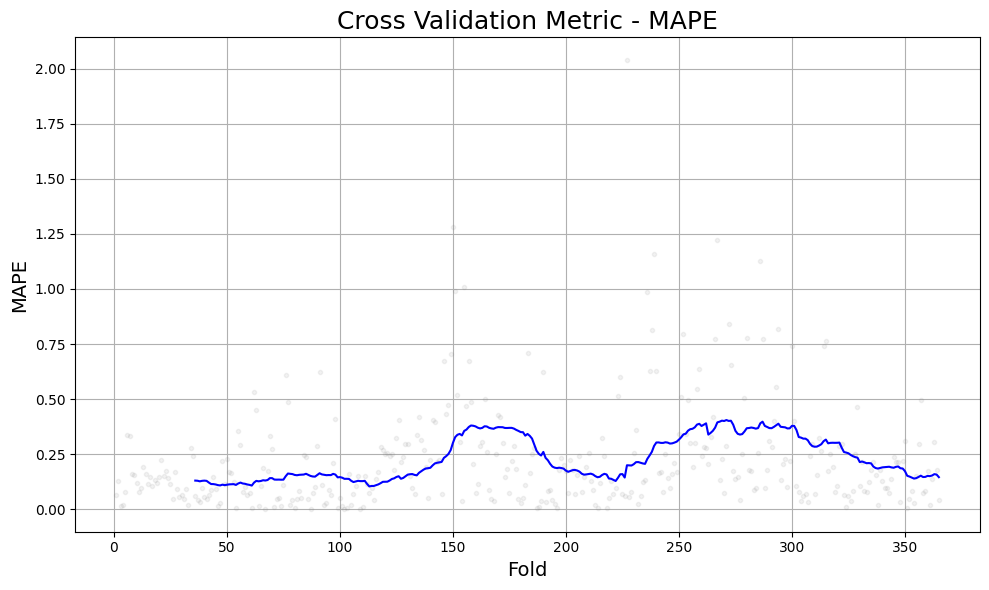

In [28]:
fig3 = plot_cross_validation_metric(df_cv, metric='mape')

plt.title("Cross Validation Metric - MAPE", fontsize=18)
plt.xlabel("Fold", fontsize=14)
plt.ylabel("MAPE", fontsize=14)

plt.tight_layout()

plt.show()


In [34]:
import pandas as pd

# Take inputs from the user
specific_date = input("Enter the date (YYYY-MM-DD): ")
temperature = float(input("Enter the temperature (in °C): "))
is_working_day = int(input("Is it a working day? (1 for Yes, 0 for No): "))

# Determine the month from the specific date
month = pd.to_datetime(specific_date).month

# Determine if the temperature is considered summer temperature
summer_temp = 1 if temperature > 20 else 0

# Create the month bins based on the given month
month_bins = pd.cut([month], bins=3, labels=False)[0]

# Prepare the input data for prediction
input_data = pd.DataFrame({
    'ds': [specific_date],
    'summer_temp': [summer_temp],
    'month_bins': [month_bins],
    'Is_Working_Day': [is_working_day],
    'temp': [temperature]  # Include temperature if you plan to use it
})

# Ensure the 'ds' column is of datetime type
input_data['ds'] = pd.to_datetime(input_data['ds'])

# Predict energy consumption for the specific date
forecast = m.predict(input_data)

# Display the prediction result
predicted_value = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print("\nPrediction Results:")
print(f"Date: {predicted_value['ds'].iloc[0]}")
print(f"Predicted Energy Consumption (yhat): {predicted_value['yhat'].iloc[0]:.2f}")
print(f"Lower Bound (yhat_lower): {predicted_value['yhat_lower'].iloc[0]:.2f}")
print(f"Upper Bound (yhat_upper): {predicted_value['yhat_upper'].iloc[0]:.2f}")


Enter the date (YYYY-MM-DD): 2013-03-25
Enter the temperature (in °C): 19
Is it a working day? (1 for Yes, 0 for No): 1

Prediction Results:
Date: 2013-03-25 00:00:00
Predicted Energy Consumption (yhat): 50.90
Lower Bound (yhat_lower): 41.04
Upper Bound (yhat_upper): 61.66


In [30]:
import pickle
import os

# Specify the directory and filename where you want to save the model
file_path = "/content/drive/MyDrive/Main Project/Models/prophet_model.pkl"

# Ensure the directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Save the model to the specified location
with open(file_path, 'wb') as f:
    pickle.dump(m, f)

print(f"Model saved to {file_path}")


Model saved to /content/drive/MyDrive/Main Project/Models/prophet_model.pkl


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
